In [1]:
import keras
import scipy
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer

from numba import jit, float64, int64

plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize

In [2]:
@jit(nopython=True)
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b:
            ch = 1.0
            stop = True
        elif x[0]>= b and x[1]>=b:
            rt = 0
            x = np.array([0.0, 0.0])
    return rt+ndt, ch

In [3]:
df1 = pd.read_csv('../../../_data/Sepulveda_et_al_2020-master/data/value/GlamDataFF2018_Dislike_NoBin.csv', index_col=0)
df2 = pd.read_csv('../../../_data/Sepulveda_et_al_2020-master/data/value/GlamDataFF2018_Like_NoBin.csv', index_col=0)
df1['goal'] = -1
df2['goal'] = 1
data_df = pd.concat([df1, df2]).sort_values(by=['subject', 'trial'])
data_df.reset_index(drop=True, inplace=True)

data_df['rt'] /= 1000

data_df.rename(columns={'subject': 'sbj'}, inplace=True)
data_df['sbj'] = data_df['sbj'].map({data_df['sbj'].unique()[i]:i for i in range(len(data_df['sbj'].unique()))})

mean_rt = data_df.groupby('sbj')['rt'].mean()
std_rt = data_df.groupby('sbj')['rt'].std()
RT_Max = mean_rt + 3 * std_rt

rt_max = []
for i in range(data_df.shape[0]):
    rt_max.append(RT_Max[data_df['sbj'][i]])
data_df['rt_max'] = rt_max
data_df = data_df[(data_df['rt']>0.25) & (data_df['rt']<data_df['rt_max'])].reset_index(drop=True)

data_df.reset_index(drop=True, inplace=True)

data_df['value diff'] = data_df['item_value_1'] - data_df['item_value_0']
kbins = KBinsDiscretizer(n_bins=11, encode='ordinal', strategy='uniform')
data_df['value diff'] = kbins.fit_transform(data_df[['value diff']])
mms = MinMaxScaler(feature_range=(-5, 5))
data_df['Right Value - Left Value'] = mms.fit_transform(data_df[['value diff']])

data_df['gaze diff'] = data_df['gaze_1'] - data_df['gaze_0']
kbins = KBinsDiscretizer(n_bins=9, encode='ordinal', strategy='uniform')
data_df['gaze diff'] = kbins.fit_transform(data_df[['gaze diff']])
mms = MinMaxScaler(feature_range=(-1, 1))
data_df['Dwell Time Advantage (R - L)'] = mms.fit_transform(data_df[['gaze diff']])

min_rt = data_df.groupby(by='sbj')['rt'].min()

In [4]:
tr_df, ts_df = data_df.copy(), data_df.copy()

obs_train = np.asarray(data_df[['rt', 'choice', 'sbj']])
X_train = np.asarray(data_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1', 'goal']])

obs_test = np.asarray(data_df[['rt', 'choice', 'sbj']])
X_test = np.asarray(data_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1', 'goal']])

print(X_train.shape, X_test.shape)

(7289, 5) (7289, 5)


In [5]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):

    sbj_indices = tf.cast(data[:, 2], tf.int32)

    # Gather values directly using TensorFlow operations
    gathered_min_rt = tf.gather(min_rt, sbj_indices)
    sigmoid_weights = tf.gather(model.layers[-1].weights[-1], sbj_indices)
    ndt = gathered_min_rt * tf.math.sigmoid(sigmoid_weights)

    thr_weights = tf.gather(model.layers[-1].weights[-2], sbj_indices)
    thr = tf.math.log(1 + tf.exp(thr_weights))

    scl_weights = tf.gather(model.layers[-1].weights[-3], sbj_indices)
    scl = tf.math.log(1 + tf.exp(scl_weights))

    ll1 = (1 - data[:, 1]) * fpt(data[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(data[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (data[:, 1]) * fpt(data[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(data[:, 0]-ndt, thr, scl*pred[:, 0]))

    return -2*tf.reduce_sum(tf.math.log(tf.maximum(ll1 + ll2, 1e-14)), axis=-1)

In [6]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [7]:
layers_neuron = [10, 10, 10, 8]
input_shape = 5
output_shape = 2
activation = 'tanh'
n_sbj = tr_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                60        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 8)                 88        
                                                                 
 out_layer (Out_layer)       (None, 2)                 111       
                                                                 
Total params: 479 (1.87 KB)
Trainable params: 479 (1.87 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [8]:
sbj_indices = tf.cast(obs_train[:, 2], tf.int32)
obs_train = tf.cast(obs_train, tf.float32)
X_train = tf.convert_to_tensor(X_train)
X_train = tf.cast(X_train, tf.float32)

min_rt = tf.convert_to_tensor(min_rt)
min_rt = tf.cast(min_rt, tf.float32)

In [9]:
history = model.fit(X_train, 
                    obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=3500)

Epoch 1/3500
1/1 [==============================] - 1s 624ms/step - loss: 60731.1328
Epoch 2/3500
1/1 [==============================] - 0s 4ms/step - loss: 60342.0781
Epoch 3/3500
1/1 [==============================] - 0s 3ms/step - loss: 60082.0391
Epoch 4/3500
1/1 [==============================] - 0s 3ms/step - loss: 59873.5938
Epoch 5/3500
1/1 [==============================] - 0s 3ms/step - loss: 59693.8438
Epoch 6/3500
1/1 [==============================] - 0s 3ms/step - loss: 59532.3672
Epoch 7/3500
1/1 [==============================] - 0s 3ms/step - loss: 59383.3438
Epoch 8/3500
1/1 [==============================] - 0s 3ms/step - loss: 59243.1602
Epoch 9/3500
1/1 [==============================] - 0s 3ms/step - loss: 59109.3359
Epoch 10/3500
1/1 [==============================] - 0s 3ms/step - loss: 58980.1875
Epoch 11/3500
1/1 [==============================] - 0s 3ms/step - loss: 58854.5000
Epoch 12/3500
1/1 [==============================] - 0s 3ms/step - loss: 58731.4453

1/1 [==============================] - 0s 3ms/step - loss: 50591.6016
Epoch 99/3500
1/1 [==============================] - 0s 3ms/step - loss: 50534.6055
Epoch 100/3500
1/1 [==============================] - 0s 3ms/step - loss: 50478.2539
Epoch 101/3500
1/1 [==============================] - 0s 3ms/step - loss: 50422.5312
Epoch 102/3500
1/1 [==============================] - 0s 3ms/step - loss: 50367.4219
Epoch 103/3500
1/1 [==============================] - 0s 3ms/step - loss: 50312.9102
Epoch 104/3500
1/1 [==============================] - 0s 3ms/step - loss: 50258.9922
Epoch 105/3500
1/1 [==============================] - 0s 3ms/step - loss: 50205.6562
Epoch 106/3500
1/1 [==============================] - 0s 3ms/step - loss: 50152.8750
Epoch 107/3500
1/1 [==============================] - 0s 3ms/step - loss: 50100.6523
Epoch 108/3500
1/1 [==============================] - 0s 3ms/step - loss: 50048.9766
Epoch 109/3500
1/1 [==============================] - 0s 3ms/step - loss: 49997.8

1/1 [==============================] - 0s 3ms/step - loss: 46868.8281
Epoch 195/3500
1/1 [==============================] - 0s 3ms/step - loss: 46841.1172
Epoch 196/3500
1/1 [==============================] - 0s 3ms/step - loss: 46813.5391
Epoch 197/3500
1/1 [==============================] - 0s 3ms/step - loss: 46786.0898
Epoch 198/3500
1/1 [==============================] - 0s 4ms/step - loss: 46758.7891
Epoch 199/3500
1/1 [==============================] - 0s 3ms/step - loss: 46731.6094
Epoch 200/3500
1/1 [==============================] - 0s 3ms/step - loss: 46704.5508
Epoch 201/3500
1/1 [==============================] - 0s 3ms/step - loss: 46677.6250
Epoch 202/3500
1/1 [==============================] - 0s 3ms/step - loss: 46650.8281
Epoch 203/3500
1/1 [==============================] - 0s 4ms/step - loss: 46624.1484
Epoch 204/3500
1/1 [==============================] - 0s 3ms/step - loss: 46597.6016
Epoch 205/3500
1/1 [==============================] - 0s 3ms/step - loss: 46571.

1/1 [==============================] - 0s 4ms/step - loss: 44650.3633
Epoch 291/3500
1/1 [==============================] - 0s 3ms/step - loss: 44630.5859
Epoch 292/3500
1/1 [==============================] - 0s 3ms/step - loss: 44610.8555
Epoch 293/3500
1/1 [==============================] - 0s 3ms/step - loss: 44591.1719
Epoch 294/3500
1/1 [==============================] - 0s 4ms/step - loss: 44571.5430
Epoch 295/3500
1/1 [==============================] - 0s 3ms/step - loss: 44551.9492
Epoch 296/3500
1/1 [==============================] - 0s 3ms/step - loss: 44532.4102
Epoch 297/3500
1/1 [==============================] - 0s 4ms/step - loss: 44512.9219
Epoch 298/3500
1/1 [==============================] - 0s 4ms/step - loss: 44493.4688
Epoch 299/3500
1/1 [==============================] - 0s 4ms/step - loss: 44474.0664
Epoch 300/3500
1/1 [==============================] - 0s 3ms/step - loss: 44454.7109
Epoch 301/3500
1/1 [==============================] - 0s 3ms/step - loss: 44435.

1/1 [==============================] - 0s 4ms/step - loss: 42926.0547
Epoch 387/3500
1/1 [==============================] - 0s 3ms/step - loss: 42909.5703
Epoch 388/3500
1/1 [==============================] - 0s 3ms/step - loss: 42893.1328
Epoch 389/3500
1/1 [==============================] - 0s 3ms/step - loss: 42876.6953
Epoch 390/3500
1/1 [==============================] - 0s 3ms/step - loss: 42860.2969
Epoch 391/3500
1/1 [==============================] - 0s 4ms/step - loss: 42843.9219
Epoch 392/3500
1/1 [==============================] - 0s 4ms/step - loss: 42827.5625
Epoch 393/3500
1/1 [==============================] - 0s 4ms/step - loss: 42811.2305
Epoch 394/3500
1/1 [==============================] - 0s 3ms/step - loss: 42794.9297
Epoch 395/3500
1/1 [==============================] - 0s 3ms/step - loss: 42778.6523
Epoch 396/3500
1/1 [==============================] - 0s 3ms/step - loss: 42762.3945
Epoch 397/3500
1/1 [==============================] - 0s 3ms/step - loss: 42746.

1/1 [==============================] - 0s 4ms/step - loss: 41445.1797
Epoch 483/3500
1/1 [==============================] - 0s 3ms/step - loss: 41430.7188
Epoch 484/3500
1/1 [==============================] - 0s 4ms/step - loss: 41416.2812
Epoch 485/3500
1/1 [==============================] - 0s 4ms/step - loss: 41401.8633
Epoch 486/3500
1/1 [==============================] - 0s 4ms/step - loss: 41387.4609
Epoch 487/3500
1/1 [==============================] - 0s 3ms/step - loss: 41373.0742
Epoch 488/3500
1/1 [==============================] - 0s 4ms/step - loss: 41358.7070
Epoch 489/3500
1/1 [==============================] - 0s 4ms/step - loss: 41344.3594
Epoch 490/3500
1/1 [==============================] - 0s 4ms/step - loss: 41330.0391
Epoch 491/3500
1/1 [==============================] - 0s 3ms/step - loss: 41315.7227
Epoch 492/3500
1/1 [==============================] - 0s 3ms/step - loss: 41301.4297
Epoch 493/3500
1/1 [==============================] - 0s 3ms/step - loss: 41287.

1/1 [==============================] - 0s 3ms/step - loss: 40118.6172
Epoch 579/3500
1/1 [==============================] - 0s 3ms/step - loss: 40105.2578
Epoch 580/3500
1/1 [==============================] - 0s 3ms/step - loss: 40091.8984
Epoch 581/3500
1/1 [==============================] - 0s 3ms/step - loss: 40078.5352
Epoch 582/3500
1/1 [==============================] - 0s 3ms/step - loss: 40065.1758
Epoch 583/3500
1/1 [==============================] - 0s 4ms/step - loss: 40051.8242
Epoch 584/3500
1/1 [==============================] - 0s 4ms/step - loss: 40038.4648
Epoch 585/3500
1/1 [==============================] - 0s 3ms/step - loss: 40025.1094
Epoch 586/3500
1/1 [==============================] - 0s 3ms/step - loss: 40011.7500
Epoch 587/3500
1/1 [==============================] - 0s 3ms/step - loss: 39998.3906
Epoch 588/3500
1/1 [==============================] - 0s 3ms/step - loss: 39985.0078
Epoch 589/3500
1/1 [==============================] - 0s 3ms/step - loss: 39971.

1/1 [==============================] - 0s 4ms/step - loss: 38620.6016
Epoch 675/3500
1/1 [==============================] - 0s 4ms/step - loss: 38604.1562
Epoch 676/3500
1/1 [==============================] - 0s 4ms/step - loss: 38587.7812
Epoch 677/3500
1/1 [==============================] - 0s 3ms/step - loss: 38571.4688
Epoch 678/3500
1/1 [==============================] - 0s 3ms/step - loss: 38555.2109
Epoch 679/3500
1/1 [==============================] - 0s 3ms/step - loss: 38539.0352
Epoch 680/3500
1/1 [==============================] - 0s 4ms/step - loss: 38522.9219
Epoch 681/3500
1/1 [==============================] - 0s 4ms/step - loss: 38506.8828
Epoch 682/3500
1/1 [==============================] - 0s 4ms/step - loss: 38490.9180
Epoch 683/3500
1/1 [==============================] - 0s 4ms/step - loss: 38475.0273
Epoch 684/3500
1/1 [==============================] - 0s 3ms/step - loss: 38459.2148
Epoch 685/3500
1/1 [==============================] - 0s 4ms/step - loss: 38443.

1/1 [==============================] - 0s 4ms/step - loss: 37310.4453
Epoch 771/3500
1/1 [==============================] - 0s 4ms/step - loss: 37298.5469
Epoch 772/3500
1/1 [==============================] - 0s 4ms/step - loss: 37286.5781
Epoch 773/3500
1/1 [==============================] - 0s 4ms/step - loss: 37274.7227
Epoch 774/3500
1/1 [==============================] - 0s 3ms/step - loss: 37262.7930
Epoch 775/3500
1/1 [==============================] - 0s 3ms/step - loss: 37250.9844
Epoch 776/3500
1/1 [==============================] - 0s 3ms/step - loss: 37239.0898
Epoch 777/3500
1/1 [==============================] - 0s 4ms/step - loss: 37227.3125
Epoch 778/3500
1/1 [==============================] - 0s 4ms/step - loss: 37215.4531
Epoch 779/3500
1/1 [==============================] - 0s 3ms/step - loss: 37203.7031
Epoch 780/3500
1/1 [==============================] - 0s 3ms/step - loss: 37191.8750
Epoch 781/3500
1/1 [==============================] - 0s 4ms/step - loss: 37180.

1/1 [==============================] - 0s 4ms/step - loss: 36201.4688
Epoch 867/3500
1/1 [==============================] - 0s 3ms/step - loss: 36190.1172
Epoch 868/3500
1/1 [==============================] - 0s 4ms/step - loss: 36178.6797
Epoch 869/3500
1/1 [==============================] - 0s 4ms/step - loss: 36167.3242
Epoch 870/3500
1/1 [==============================] - 0s 4ms/step - loss: 36155.8828
Epoch 871/3500
1/1 [==============================] - 0s 3ms/step - loss: 36144.5312
Epoch 872/3500
1/1 [==============================] - 0s 3ms/step - loss: 36133.0898
Epoch 873/3500
1/1 [==============================] - 0s 3ms/step - loss: 36121.7344
Epoch 874/3500
1/1 [==============================] - 0s 4ms/step - loss: 36110.2891
Epoch 875/3500
1/1 [==============================] - 0s 3ms/step - loss: 36098.9297
Epoch 876/3500
1/1 [==============================] - 0s 3ms/step - loss: 36087.4844
Epoch 877/3500
1/1 [==============================] - 0s 3ms/step - loss: 36076.

1/1 [==============================] - 0s 4ms/step - loss: 34735.1367
Epoch 963/3500
1/1 [==============================] - 0s 3ms/step - loss: 34716.0234
Epoch 964/3500
1/1 [==============================] - 0s 3ms/step - loss: 34697.1367
Epoch 965/3500
1/1 [==============================] - 0s 3ms/step - loss: 34678.5859
Epoch 966/3500
1/1 [==============================] - 0s 3ms/step - loss: 34660.2344
Epoch 967/3500
1/1 [==============================] - 0s 4ms/step - loss: 34642.1797
Epoch 968/3500
1/1 [==============================] - 0s 3ms/step - loss: 34624.2773
Epoch 969/3500
1/1 [==============================] - 0s 3ms/step - loss: 34606.6445
Epoch 970/3500
1/1 [==============================] - 0s 4ms/step - loss: 34589.1406
Epoch 971/3500
1/1 [==============================] - 0s 3ms/step - loss: 34571.8750
Epoch 972/3500
1/1 [==============================] - 0s 3ms/step - loss: 34554.7109
Epoch 973/3500
1/1 [==============================] - 0s 3ms/step - loss: 34537.

1/1 [==============================] - 0s 4ms/step - loss: 33156.9062
Epoch 1058/3500
1/1 [==============================] - 0s 3ms/step - loss: 33143.9453
Epoch 1059/3500
1/1 [==============================] - 0s 4ms/step - loss: 33131.0234
Epoch 1060/3500
1/1 [==============================] - 0s 4ms/step - loss: 33118.1953
Epoch 1061/3500
1/1 [==============================] - 0s 4ms/step - loss: 33105.3984
Epoch 1062/3500
1/1 [==============================] - 0s 4ms/step - loss: 33092.7188
Epoch 1063/3500
1/1 [==============================] - 0s 4ms/step - loss: 33080.0547
Epoch 1064/3500
1/1 [==============================] - 0s 3ms/step - loss: 33067.5312
Epoch 1065/3500
1/1 [==============================] - 0s 4ms/step - loss: 33054.9766
Epoch 1066/3500
1/1 [==============================] - 0s 3ms/step - loss: 33042.5703
Epoch 1067/3500
1/1 [==============================] - 0s 3ms/step - loss: 33030.0742
Epoch 1068/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 32109.6504
Epoch 1153/3500
1/1 [==============================] - 0s 4ms/step - loss: 32099.6348
Epoch 1154/3500
1/1 [==============================] - 0s 3ms/step - loss: 32089.7227
Epoch 1155/3500
1/1 [==============================] - 0s 3ms/step - loss: 32079.5352
Epoch 1156/3500
1/1 [==============================] - 0s 3ms/step - loss: 32069.5000
Epoch 1157/3500
1/1 [==============================] - 0s 4ms/step - loss: 32059.3145
Epoch 1158/3500
1/1 [==============================] - 0s 3ms/step - loss: 32049.3008
Epoch 1159/3500
1/1 [==============================] - 0s 3ms/step - loss: 32039.2148
Epoch 1160/3500
1/1 [==============================] - 0s 3ms/step - loss: 32029.2344
Epoch 1161/3500
1/1 [==============================] - 0s 4ms/step - loss: 32019.1582
Epoch 1162/3500
1/1 [==============================] - 0s 3ms/step - loss: 32009.1133
Epoch 1163/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 30684.9844
Epoch 1248/3500
1/1 [==============================] - 0s 3ms/step - loss: 30672.7656
Epoch 1249/3500
1/1 [==============================] - 0s 4ms/step - loss: 30660.5664
Epoch 1250/3500
1/1 [==============================] - 0s 4ms/step - loss: 30648.6113
Epoch 1251/3500
1/1 [==============================] - 0s 3ms/step - loss: 30636.6641
Epoch 1252/3500
1/1 [==============================] - 0s 3ms/step - loss: 30624.9531
Epoch 1253/3500
1/1 [==============================] - 0s 3ms/step - loss: 30613.2422
Epoch 1254/3500
1/1 [==============================] - 0s 3ms/step - loss: 30601.7559
Epoch 1255/3500
1/1 [==============================] - 0s 3ms/step - loss: 30590.2578
Epoch 1256/3500
1/1 [==============================] - 0s 3ms/step - loss: 30578.9766
Epoch 1257/3500
1/1 [==============================] - 0s 3ms/step - loss: 30567.6797
Epoch 1258/3500
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 29819.7051
Epoch 1343/3500
1/1 [==============================] - 0s 5ms/step - loss: 29812.7500
Epoch 1344/3500
1/1 [==============================] - 0s 5ms/step - loss: 29805.9297
Epoch 1345/3500
1/1 [==============================] - 0s 5ms/step - loss: 29799.0508
Epoch 1346/3500
1/1 [==============================] - 0s 6ms/step - loss: 29792.2949
Epoch 1347/3500
1/1 [==============================] - 0s 6ms/step - loss: 29785.4766
Epoch 1348/3500
1/1 [==============================] - 0s 5ms/step - loss: 29778.7891
Epoch 1349/3500
1/1 [==============================] - 0s 5ms/step - loss: 29772.0371
Epoch 1350/3500
1/1 [==============================] - 0s 5ms/step - loss: 29765.4102
Epoch 1351/3500
1/1 [==============================] - 0s 5ms/step - loss: 29758.7227
Epoch 1352/3500
1/1 [==============================] - 0s 5ms/step - loss: 29752.1582
Epoch 1353/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 29276.3516
Epoch 1438/3500
1/1 [==============================] - 0s 4ms/step - loss: 29271.5547
Epoch 1439/3500
1/1 [==============================] - 0s 4ms/step - loss: 29266.6953
Epoch 1440/3500
1/1 [==============================] - 0s 4ms/step - loss: 29261.9492
Epoch 1441/3500
1/1 [==============================] - 0s 4ms/step - loss: 29257.1328
Epoch 1442/3500
1/1 [==============================] - 0s 4ms/step - loss: 29252.3828
Epoch 1443/3500
1/1 [==============================] - 0s 4ms/step - loss: 29247.5938
Epoch 1444/3500
1/1 [==============================] - 0s 4ms/step - loss: 29242.8906
Epoch 1445/3500
1/1 [==============================] - 0s 4ms/step - loss: 29238.1250
Epoch 1446/3500
1/1 [==============================] - 0s 4ms/step - loss: 29233.4297
Epoch 1447/3500
1/1 [==============================] - 0s 4ms/step - loss: 29228.7070
Epoch 1448/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 28872.2969
Epoch 1533/3500
1/1 [==============================] - 0s 4ms/step - loss: 28868.4844
Epoch 1534/3500
1/1 [==============================] - 0s 4ms/step - loss: 28864.8086
Epoch 1535/3500
1/1 [==============================] - 0s 3ms/step - loss: 28861.0371
Epoch 1536/3500
1/1 [==============================] - 0s 4ms/step - loss: 28857.3809
Epoch 1537/3500
1/1 [==============================] - 0s 3ms/step - loss: 28853.6875
Epoch 1538/3500
1/1 [==============================] - 0s 4ms/step - loss: 28850.0039
Epoch 1539/3500
1/1 [==============================] - 0s 5ms/step - loss: 28846.2500
Epoch 1540/3500
1/1 [==============================] - 0s 4ms/step - loss: 28842.6016
Epoch 1541/3500
1/1 [==============================] - 0s 4ms/step - loss: 28838.8789
Epoch 1542/3500
1/1 [==============================] - 0s 5ms/step - loss: 28835.2539
Epoch 1543/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 28551.8203
Epoch 1628/3500
1/1 [==============================] - 0s 4ms/step - loss: 28548.8594
Epoch 1629/3500
1/1 [==============================] - 0s 4ms/step - loss: 28545.8281
Epoch 1630/3500
1/1 [==============================] - 0s 4ms/step - loss: 28542.8242
Epoch 1631/3500
1/1 [==============================] - 0s 4ms/step - loss: 28539.7422
Epoch 1632/3500
1/1 [==============================] - 0s 4ms/step - loss: 28536.7500
Epoch 1633/3500
1/1 [==============================] - 0s 4ms/step - loss: 28533.6992
Epoch 1634/3500
1/1 [==============================] - 0s 4ms/step - loss: 28530.7637
Epoch 1635/3500
1/1 [==============================] - 0s 4ms/step - loss: 28527.7500
Epoch 1636/3500
1/1 [==============================] - 0s 4ms/step - loss: 28524.8516
Epoch 1637/3500
1/1 [==============================] - 0s 4ms/step - loss: 28521.8027
Epoch 1638/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 28287.3867
Epoch 1723/3500
1/1 [==============================] - 0s 4ms/step - loss: 28284.7539
Epoch 1724/3500
1/1 [==============================] - 0s 4ms/step - loss: 28282.1719
Epoch 1725/3500
1/1 [==============================] - 0s 4ms/step - loss: 28279.5449
Epoch 1726/3500
1/1 [==============================] - 0s 4ms/step - loss: 28277.0254
Epoch 1727/3500
1/1 [==============================] - 0s 4ms/step - loss: 28274.4570
Epoch 1728/3500
1/1 [==============================] - 0s 4ms/step - loss: 28272.0605
Epoch 1729/3500
1/1 [==============================] - 0s 4ms/step - loss: 28269.4590
Epoch 1730/3500
1/1 [==============================] - 0s 4ms/step - loss: 28266.9648
Epoch 1731/3500
1/1 [==============================] - 0s 4ms/step - loss: 28264.2871
Epoch 1732/3500
1/1 [==============================] - 0s 4ms/step - loss: 28261.7578
Epoch 1733/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 28059.4609
Epoch 1818/3500
1/1 [==============================] - 0s 6ms/step - loss: 28057.1094
Epoch 1819/3500
1/1 [==============================] - 0s 4ms/step - loss: 28054.7656
Epoch 1820/3500
1/1 [==============================] - 0s 5ms/step - loss: 28052.5859
Epoch 1821/3500
1/1 [==============================] - 0s 5ms/step - loss: 28050.3945
Epoch 1822/3500
1/1 [==============================] - 0s 5ms/step - loss: 28048.3652
Epoch 1823/3500
1/1 [==============================] - 0s 6ms/step - loss: 28046.1582
Epoch 1824/3500
1/1 [==============================] - 0s 5ms/step - loss: 28044.0547
Epoch 1825/3500
1/1 [==============================] - 0s 5ms/step - loss: 28041.6934
Epoch 1826/3500
1/1 [==============================] - 0s 5ms/step - loss: 28039.5254
Epoch 1827/3500
1/1 [==============================] - 0s 5ms/step - loss: 28037.1816
Epoch 1828/3500
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 27867.4102
Epoch 1913/3500
1/1 [==============================] - 0s 5ms/step - loss: 27865.4375
Epoch 1914/3500
1/1 [==============================] - 0s 4ms/step - loss: 27863.6113
Epoch 1915/3500
1/1 [==============================] - 0s 4ms/step - loss: 27861.8867
Epoch 1916/3500
1/1 [==============================] - 0s 6ms/step - loss: 27860.2812
Epoch 1917/3500
1/1 [==============================] - 0s 10ms/step - loss: 27858.5234
Epoch 1918/3500
1/1 [==============================] - 0s 12ms/step - loss: 27856.8672
Epoch 1919/3500
1/1 [==============================] - 0s 10ms/step - loss: 27854.7656
Epoch 1920/3500
1/1 [==============================] - 0s 8ms/step - loss: 27852.8984
Epoch 1921/3500
1/1 [==============================] - 0s 10ms/step - loss: 27850.8828
Epoch 1922/3500
1/1 [==============================] - 0s 6ms/step - loss: 27849.1133
Epoch 1923/3500
1/1 [==============================] - 0s 6ms/step

1/1 [==============================] - 0s 5ms/step - loss: 27708.3438
Epoch 2008/3500
1/1 [==============================] - 0s 6ms/step - loss: 27706.9863
Epoch 2009/3500
1/1 [==============================] - 0s 5ms/step - loss: 27705.7031
Epoch 2010/3500
1/1 [==============================] - 0s 5ms/step - loss: 27704.6289
Epoch 2011/3500
1/1 [==============================] - 0s 5ms/step - loss: 27703.1172
Epoch 2012/3500
1/1 [==============================] - 0s 4ms/step - loss: 27701.5352
Epoch 2013/3500
1/1 [==============================] - 0s 5ms/step - loss: 27699.6328
Epoch 2014/3500
1/1 [==============================] - 0s 5ms/step - loss: 27697.9590
Epoch 2015/3500
1/1 [==============================] - 0s 4ms/step - loss: 27696.3242
Epoch 2016/3500
1/1 [==============================] - 0s 5ms/step - loss: 27695.0391
Epoch 2017/3500
1/1 [==============================] - 0s 5ms/step - loss: 27693.8711
Epoch 2018/3500
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 27575.8652
Epoch 2103/3500
1/1 [==============================] - 0s 5ms/step - loss: 27575.0508
Epoch 2104/3500
1/1 [==============================] - 0s 6ms/step - loss: 27574.3789
Epoch 2105/3500
1/1 [==============================] - 0s 5ms/step - loss: 27573.1055
Epoch 2106/3500
1/1 [==============================] - 0s 5ms/step - loss: 27571.5195
Epoch 2107/3500
1/1 [==============================] - 0s 6ms/step - loss: 27569.6250
Epoch 2108/3500
1/1 [==============================] - 0s 5ms/step - loss: 27568.0352
Epoch 2109/3500
1/1 [==============================] - 0s 5ms/step - loss: 27566.6816
Epoch 2110/3500
1/1 [==============================] - 0s 7ms/step - loss: 27565.8105
Epoch 2111/3500
1/1 [==============================] - 0s 12ms/step - loss: 27565.1523
Epoch 2112/3500
1/1 [==============================] - 0s 6ms/step - loss: 27564.3301
Epoch 2113/3500
1/1 [==============================] - 0s 5ms/step - 

1/1 [==============================] - 0s 4ms/step - loss: 27463.8516
Epoch 2198/3500
1/1 [==============================] - 0s 5ms/step - loss: 27463.3516
Epoch 2199/3500
1/1 [==============================] - 0s 5ms/step - loss: 27463.2363
Epoch 2200/3500
1/1 [==============================] - 0s 4ms/step - loss: 27463.1426
Epoch 2201/3500
1/1 [==============================] - 0s 5ms/step - loss: 27461.9375
Epoch 2202/3500
1/1 [==============================] - 0s 6ms/step - loss: 27460.3125
Epoch 2203/3500
1/1 [==============================] - 0s 5ms/step - loss: 27458.2676
Epoch 2204/3500
1/1 [==============================] - 0s 5ms/step - loss: 27456.7422
Epoch 2205/3500
1/1 [==============================] - 0s 6ms/step - loss: 27455.6426
Epoch 2206/3500
1/1 [==============================] - 0s 5ms/step - loss: 27455.0508
Epoch 2207/3500
1/1 [==============================] - 0s 4ms/step - loss: 27454.7695
Epoch 2208/3500
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 27371.3223
Epoch 2293/3500
1/1 [==============================] - 0s 4ms/step - loss: 27369.8184
Epoch 2294/3500
1/1 [==============================] - 0s 5ms/step - loss: 27368.4512
Epoch 2295/3500
1/1 [==============================] - 0s 5ms/step - loss: 27367.6445
Epoch 2296/3500
1/1 [==============================] - 0s 4ms/step - loss: 27367.5898
Epoch 2297/3500
1/1 [==============================] - 0s 5ms/step - loss: 27367.9238
Epoch 2298/3500
1/1 [==============================] - 0s 5ms/step - loss: 27368.2402
Epoch 2299/3500
1/1 [==============================] - 0s 4ms/step - loss: 27366.9980
Epoch 2300/3500
1/1 [==============================] - 0s 6ms/step - loss: 27365.2109
Epoch 2301/3500
1/1 [==============================] - 0s 5ms/step - loss: 27363.0430
Epoch 2302/3500
1/1 [==============================] - 0s 4ms/step - loss: 27361.5723
Epoch 2303/3500
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 27292.3223
Epoch 2388/3500
1/1 [==============================] - 0s 4ms/step - loss: 27292.2969
Epoch 2389/3500
1/1 [==============================] - 0s 4ms/step - loss: 27292.7031
Epoch 2390/3500
1/1 [==============================] - 0s 4ms/step - loss: 27292.4414
Epoch 2391/3500
1/1 [==============================] - 0s 4ms/step - loss: 27291.7715
Epoch 2392/3500
1/1 [==============================] - 0s 4ms/step - loss: 27289.8457
Epoch 2393/3500
1/1 [==============================] - 0s 4ms/step - loss: 27288.4238
Epoch 2394/3500
1/1 [==============================] - 0s 4ms/step - loss: 27286.7461
Epoch 2395/3500
1/1 [==============================] - 0s 4ms/step - loss: 27285.8965
Epoch 2396/3500
1/1 [==============================] - 0s 4ms/step - loss: 27285.5410
Epoch 2397/3500
1/1 [==============================] - 0s 4ms/step - loss: 27286.1875
Epoch 2398/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 27226.5898
Epoch 2483/3500
1/1 [==============================] - 0s 4ms/step - loss: 27227.2832
Epoch 2484/3500
1/1 [==============================] - 0s 5ms/step - loss: 27229.0039
Epoch 2485/3500
1/1 [==============================] - 0s 4ms/step - loss: 27230.0410
Epoch 2486/3500
1/1 [==============================] - 0s 4ms/step - loss: 27229.0996
Epoch 2487/3500
1/1 [==============================] - 0s 4ms/step - loss: 27226.1367
Epoch 2488/3500
1/1 [==============================] - 0s 4ms/step - loss: 27223.9727
Epoch 2489/3500
1/1 [==============================] - 0s 4ms/step - loss: 27222.4297
Epoch 2490/3500
1/1 [==============================] - 0s 4ms/step - loss: 27221.8652
Epoch 2491/3500
1/1 [==============================] - 0s 4ms/step - loss: 27221.8633
Epoch 2492/3500
1/1 [==============================] - 0s 4ms/step - loss: 27222.2695
Epoch 2493/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 27172.2363
Epoch 2578/3500
1/1 [==============================] - 0s 3ms/step - loss: 27170.9473
Epoch 2579/3500
1/1 [==============================] - 0s 3ms/step - loss: 27170.6113
Epoch 2580/3500
1/1 [==============================] - 0s 3ms/step - loss: 27170.8457
Epoch 2581/3500
1/1 [==============================] - 0s 3ms/step - loss: 27171.7500
Epoch 2582/3500
1/1 [==============================] - 0s 3ms/step - loss: 27171.9160
Epoch 2583/3500
1/1 [==============================] - 0s 3ms/step - loss: 27171.8926
Epoch 2584/3500
1/1 [==============================] - 0s 3ms/step - loss: 27170.2148
Epoch 2585/3500
1/1 [==============================] - 0s 4ms/step - loss: 27168.7188
Epoch 2586/3500
1/1 [==============================] - 0s 4ms/step - loss: 27167.0820
Epoch 2587/3500
1/1 [==============================] - 0s 4ms/step - loss: 27166.0312
Epoch 2588/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 27125.4648
Epoch 2673/3500
1/1 [==============================] - 0s 4ms/step - loss: 27126.4375
Epoch 2674/3500
1/1 [==============================] - 0s 3ms/step - loss: 27126.8984
Epoch 2675/3500
1/1 [==============================] - 0s 3ms/step - loss: 27127.2188
Epoch 2676/3500
1/1 [==============================] - 0s 3ms/step - loss: 27125.9375
Epoch 2677/3500
1/1 [==============================] - 0s 4ms/step - loss: 27124.5410
Epoch 2678/3500
1/1 [==============================] - 0s 4ms/step - loss: 27122.8027
Epoch 2679/3500
1/1 [==============================] - 0s 4ms/step - loss: 27121.7734
Epoch 2680/3500
1/1 [==============================] - 0s 3ms/step - loss: 27120.8184
Epoch 2681/3500
1/1 [==============================] - 0s 4ms/step - loss: 27120.7500
Epoch 2682/3500
1/1 [==============================] - 0s 3ms/step - loss: 27121.0449
Epoch 2683/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 27085.0039
Epoch 2768/3500
1/1 [==============================] - 0s 4ms/step - loss: 27085.6133
Epoch 2769/3500
1/1 [==============================] - 0s 3ms/step - loss: 27086.9297
Epoch 2770/3500
1/1 [==============================] - 0s 4ms/step - loss: 27087.1523
Epoch 2771/3500
1/1 [==============================] - 0s 4ms/step - loss: 27087.1074
Epoch 2772/3500
1/1 [==============================] - 0s 4ms/step - loss: 27085.1445
Epoch 2773/3500
1/1 [==============================] - 0s 3ms/step - loss: 27084.1270
Epoch 2774/3500
1/1 [==============================] - 0s 4ms/step - loss: 27082.3730
Epoch 2775/3500
1/1 [==============================] - 0s 3ms/step - loss: 27081.7031
Epoch 2776/3500
1/1 [==============================] - 0s 4ms/step - loss: 27080.7988
Epoch 2777/3500
1/1 [==============================] - 0s 4ms/step - loss: 27080.9434
Epoch 2778/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 27051.1484
Epoch 2863/3500
1/1 [==============================] - 0s 4ms/step - loss: 27049.5508
Epoch 2864/3500
1/1 [==============================] - 0s 4ms/step - loss: 27048.9961
Epoch 2865/3500
1/1 [==============================] - 0s 3ms/step - loss: 27049.1797
Epoch 2866/3500
1/1 [==============================] - 0s 3ms/step - loss: 27050.1602
Epoch 2867/3500
1/1 [==============================] - 0s 3ms/step - loss: 27051.7402
Epoch 2868/3500
1/1 [==============================] - 0s 3ms/step - loss: 27052.2969
Epoch 2869/3500
1/1 [==============================] - 0s 3ms/step - loss: 27052.4531
Epoch 2870/3500
1/1 [==============================] - 0s 4ms/step - loss: 27050.5000
Epoch 2871/3500
1/1 [==============================] - 0s 3ms/step - loss: 27049.1016
Epoch 2872/3500
1/1 [==============================] - 0s 3ms/step - loss: 27047.4551
Epoch 2873/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 27021.6660
Epoch 2958/3500
1/1 [==============================] - 0s 3ms/step - loss: 27024.6484
Epoch 2959/3500
1/1 [==============================] - 0s 4ms/step - loss: 27028.6094
Epoch 2960/3500
1/1 [==============================] - 0s 3ms/step - loss: 27029.0547
Epoch 2961/3500
1/1 [==============================] - 0s 4ms/step - loss: 27024.7988
Epoch 2962/3500
1/1 [==============================] - 0s 3ms/step - loss: 27021.2383
Epoch 2963/3500
1/1 [==============================] - 0s 4ms/step - loss: 27018.9805
Epoch 2964/3500
1/1 [==============================] - 0s 3ms/step - loss: 27018.2422
Epoch 2965/3500
1/1 [==============================] - 0s 3ms/step - loss: 27018.2305
Epoch 2966/3500
1/1 [==============================] - 0s 3ms/step - loss: 27018.4961
Epoch 2967/3500
1/1 [==============================] - 0s 4ms/step - loss: 27019.9922
Epoch 2968/3500
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 26997.2520
Epoch 3053/3500
1/1 [==============================] - 0s 4ms/step - loss: 26995.9258
Epoch 3054/3500
1/1 [==============================] - 0s 4ms/step - loss: 26994.6777
Epoch 3055/3500
1/1 [==============================] - 0s 4ms/step - loss: 26994.2812
Epoch 3056/3500
1/1 [==============================] - 0s 4ms/step - loss: 26993.7598
Epoch 3057/3500
1/1 [==============================] - 0s 4ms/step - loss: 26994.5371
Epoch 3058/3500
1/1 [==============================] - 0s 4ms/step - loss: 26995.7012
Epoch 3059/3500
1/1 [==============================] - 0s 4ms/step - loss: 26998.4219
Epoch 3060/3500
1/1 [==============================] - 0s 4ms/step - loss: 27001.9082
Epoch 3061/3500
1/1 [==============================] - 0s 5ms/step - loss: 27001.5391
Epoch 3062/3500
1/1 [==============================] - 0s 4ms/step - loss: 26998.3359
Epoch 3063/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 26974.0352
Epoch 3148/3500
1/1 [==============================] - 0s 4ms/step - loss: 26972.7012
Epoch 3149/3500
1/1 [==============================] - 0s 4ms/step - loss: 26972.2051
Epoch 3150/3500
1/1 [==============================] - 0s 4ms/step - loss: 26972.8438
Epoch 3151/3500
1/1 [==============================] - 0s 4ms/step - loss: 26974.1855
Epoch 3152/3500
1/1 [==============================] - 0s 3ms/step - loss: 26975.5625
Epoch 3153/3500
1/1 [==============================] - 0s 3ms/step - loss: 26977.4766
Epoch 3154/3500
1/1 [==============================] - 0s 3ms/step - loss: 26977.2617
Epoch 3155/3500
1/1 [==============================] - 0s 3ms/step - loss: 26976.3750
Epoch 3156/3500
1/1 [==============================] - 0s 3ms/step - loss: 26974.0664
Epoch 3157/3500
1/1 [==============================] - 0s 4ms/step - loss: 26972.6445
Epoch 3158/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 26958.7168
Epoch 3243/3500
1/1 [==============================] - 0s 4ms/step - loss: 26957.8223
Epoch 3244/3500
1/1 [==============================] - 0s 4ms/step - loss: 26955.8125
Epoch 3245/3500
1/1 [==============================] - 0s 4ms/step - loss: 26954.8789
Epoch 3246/3500
1/1 [==============================] - 0s 4ms/step - loss: 26954.4336
Epoch 3247/3500
1/1 [==============================] - 0s 3ms/step - loss: 26954.6074
Epoch 3248/3500
1/1 [==============================] - 0s 4ms/step - loss: 26955.5352
Epoch 3249/3500
1/1 [==============================] - 0s 4ms/step - loss: 26959.0625
Epoch 3250/3500
1/1 [==============================] - 0s 4ms/step - loss: 26962.5000
Epoch 3251/3500
1/1 [==============================] - 0s 4ms/step - loss: 26962.8066
Epoch 3252/3500
1/1 [==============================] - 0s 4ms/step - loss: 26959.8652
Epoch 3253/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 26940.8867
Epoch 3338/3500
1/1 [==============================] - 0s 3ms/step - loss: 26939.8750
Epoch 3339/3500
1/1 [==============================] - 0s 4ms/step - loss: 26940.8789
Epoch 3340/3500
1/1 [==============================] - 0s 4ms/step - loss: 26940.5195
Epoch 3341/3500
1/1 [==============================] - 0s 4ms/step - loss: 26942.1523
Epoch 3342/3500
1/1 [==============================] - 0s 3ms/step - loss: 26943.0312
Epoch 3343/3500
1/1 [==============================] - 0s 4ms/step - loss: 26943.5566
Epoch 3344/3500
1/1 [==============================] - 0s 4ms/step - loss: 26942.9922
Epoch 3345/3500
1/1 [==============================] - 0s 3ms/step - loss: 26943.0078
Epoch 3346/3500
1/1 [==============================] - 0s 4ms/step - loss: 26940.5156
Epoch 3347/3500
1/1 [==============================] - 0s 4ms/step - loss: 26939.0859
Epoch 3348/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 26926.3359
Epoch 3433/3500
1/1 [==============================] - 0s 4ms/step - loss: 26926.6836
Epoch 3434/3500
1/1 [==============================] - 0s 3ms/step - loss: 26928.9004
Epoch 3435/3500
1/1 [==============================] - 0s 3ms/step - loss: 26932.2012
Epoch 3436/3500
1/1 [==============================] - 0s 3ms/step - loss: 26935.3867
Epoch 3437/3500
1/1 [==============================] - 0s 4ms/step - loss: 26935.0801
Epoch 3438/3500
1/1 [==============================] - 0s 3ms/step - loss: 26931.6777
Epoch 3439/3500
1/1 [==============================] - 0s 4ms/step - loss: 26928.3828
Epoch 3440/3500
1/1 [==============================] - 0s 4ms/step - loss: 26925.1875
Epoch 3441/3500
1/1 [==============================] - 0s 4ms/step - loss: 26923.3789
Epoch 3442/3500
1/1 [==============================] - 0s 4ms/step - loss: 26922.8203
Epoch 3443/3500
1/1 [==============================] - 0s 3ms/step - l

In [10]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

228/228 [==============================] - 0s 335us/step


In [11]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': [],
            'goal':[],
            'value_diff': [],
            'gaze_diff': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i] for i in ts_df['sbj']])

for n in range(10):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]], ndt[ts_df.sbj[s]])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
        pred_bhv['goal'].append(ts_df.goal[s])
        pred_bhv['value_diff'].append(ts_df['Right Value - Left Value'][s])
        pred_bhv['gaze_diff'].append(ts_df['Dwell Time Advantage (R - L)'][s])
        
pred_bhv = pd.DataFrame(pred_bhv)

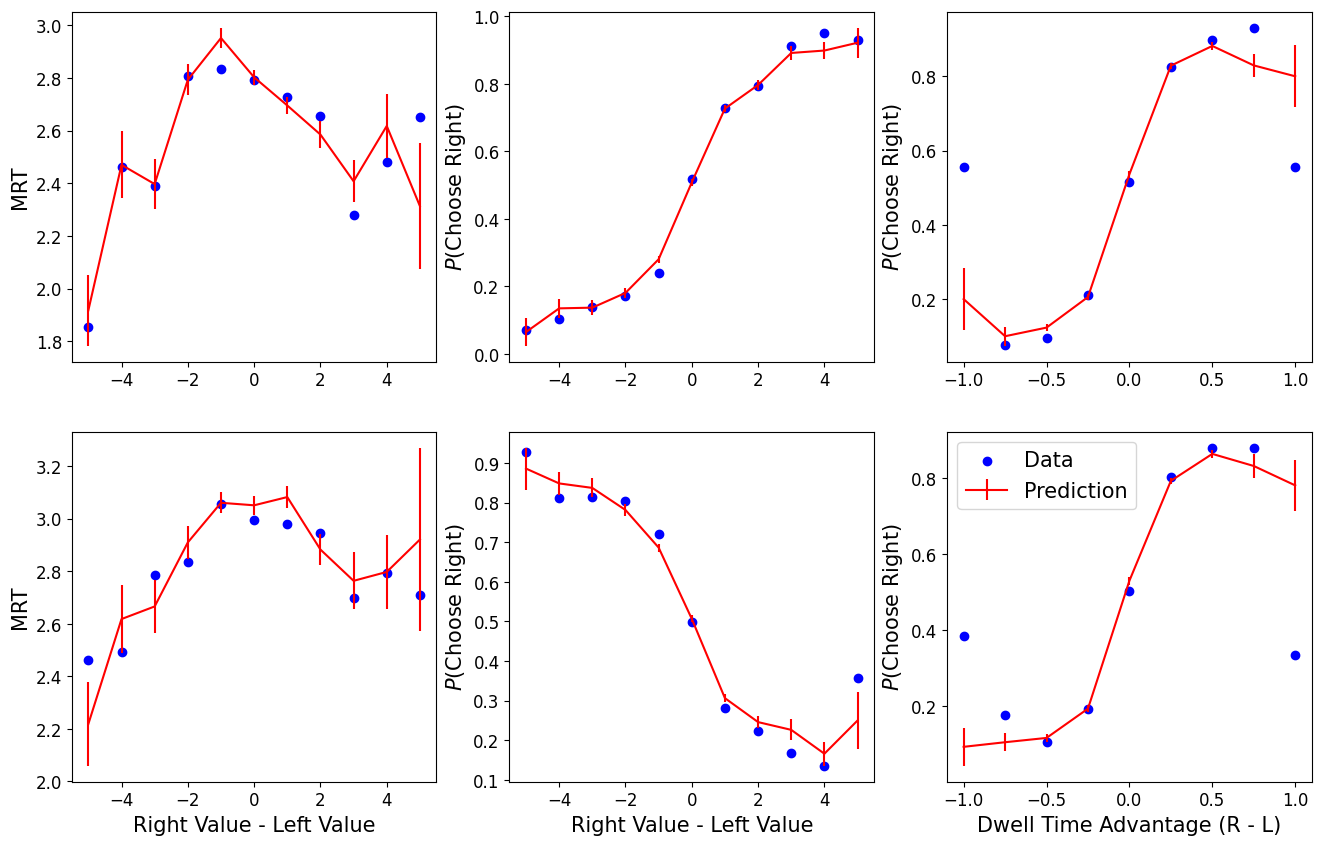

In [12]:
plt.figure(figsize=(16, 10))
plt.subplot(231)
se = pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['rt'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['rt'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['rt'].mean(), c='blue');
plt.ylabel('MRT');

plt.subplot(232)
se = pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['ch'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['choice'].mean(), c='blue');
plt.ylabel(r'$P$(Choose Right)');

plt.subplot(233)
se = pred_bhv[pred_bhv['goal']==1].groupby(by='gaze_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==1].groupby(by='gaze_diff')['gaze_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==1].groupby(by='gaze_diff')['ch'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==1].groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df[ts_df['goal']==1].groupby(by='Dwell Time Advantage (R - L)')['choice'].mean(), c='blue');
plt.ylabel(r'$P$(Choose Right)');

###########
plt.subplot(234)
se = pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['rt'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==-1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['rt'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['rt'].mean(), c='blue');
plt.xlabel('Right Value - Left Value');
plt.ylabel('MRT');

plt.subplot(235)
se = pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==-1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['ch'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['choice'].mean(), c='blue');
plt.xlabel('Right Value - Left Value');
plt.ylabel(r'$P$(Choose Right)');

plt.subplot(236)
se = pred_bhv[pred_bhv['goal']==-1].groupby(by='gaze_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==-1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==-1].groupby(by='gaze_diff')['gaze_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==-1].groupby(by='gaze_diff')['ch'].mean(),
             yerr=h, label='Prediction', c='red');
plt.scatter(x=ts_df[ts_df['goal']==-1].groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df[ts_df['goal']==-1].groupby(by='Dwell Time Advantage (R - L)')['choice'].mean(), c='blue', label='Data');
plt.xlabel('Dwell Time Advantage (R - L)');
plt.ylabel(r'$P$(Choose Right)');
plt.legend();

plt.savefig('_plots/sp2020_valuebased_complete_postpred.pdf', 
            dpi=600, 
            transparent=True, 
            bbox_inches='tight');

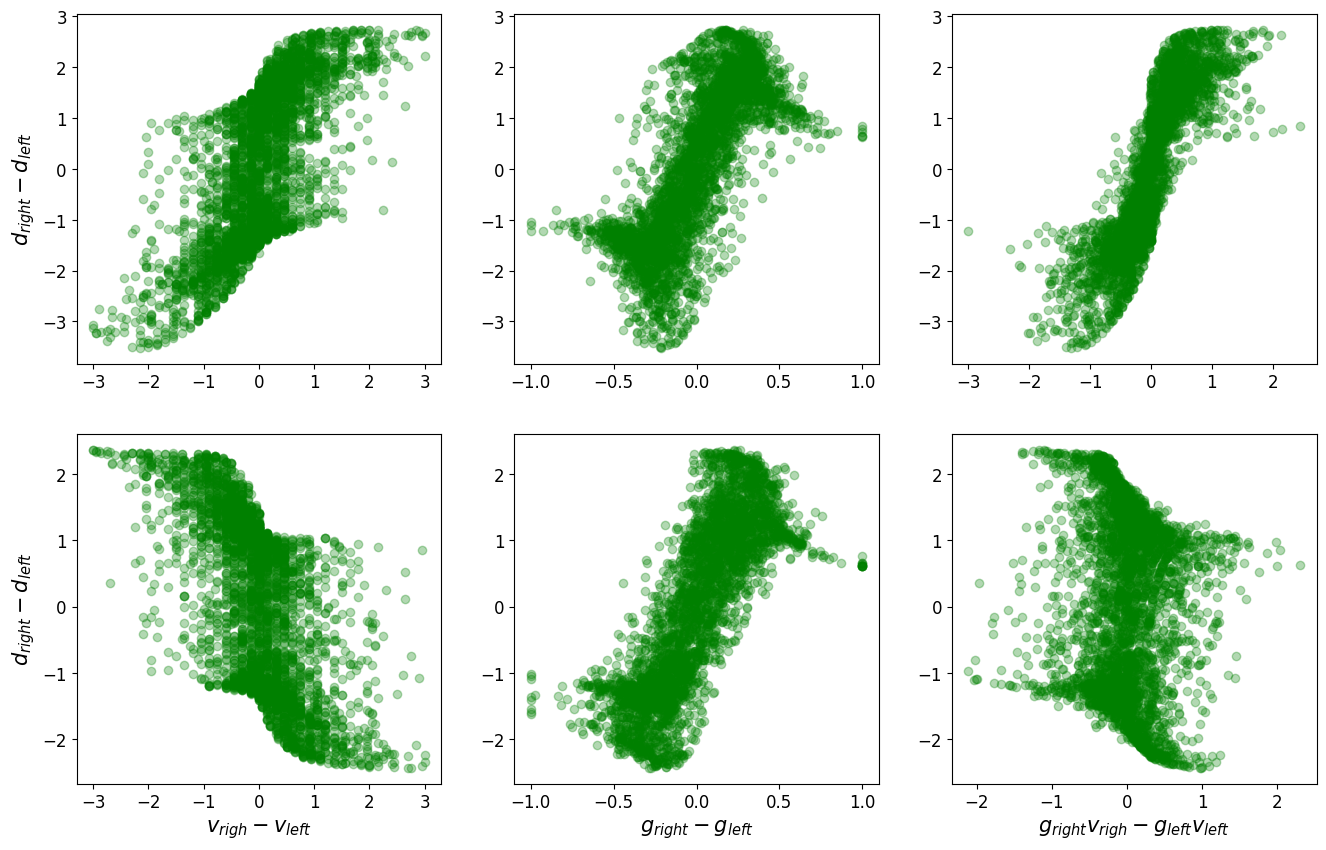

In [13]:
plt.figure(figsize=(16, 10))
plt.subplot(231)
plt.scatter(X_test[X_test[:, -1]==1, 1] - X_test[X_test[:, -1]==1, 0], 
            pred_v[X_test[:, -1]==1, 1] - pred_v[X_test[:, -1]==1, 0], 
            alpha=0.3, c='green');
plt.ylabel(r'$d_{right} - d_{left}$');

plt.subplot(232)
plt.scatter(X_test[X_test[:, -1]==1, 3] - X_test[X_test[:, -1]==1, 2], 
            pred_v[X_test[:, -1]==1, 1] - pred_v[X_test[:, -1]==1, 0], 
            alpha=0.3, c='green');


plt.subplot(233)
plt.scatter(X_test[X_test[:, -1]==1, 1]*X_test[X_test[:, -1]==1, 3] - X_test[X_test[:, -1]==1, 0]*X_test[X_test[:, -1]==1, 2], 
            pred_v[X_test[:, -1]==1, 1] - pred_v[X_test[:, -1]==1, 0], 
            alpha=0.3, c='green');

#####################
plt.subplot(234)
plt.scatter(X_test[X_test[:, -1]==-1, 1] - X_test[X_test[:, -1]==-1, 0], 
            pred_v[X_test[:, -1]==-1, 1] - pred_v[X_test[:, -1]==-1, 0], 
            alpha=0.3, c='green');
plt.xlabel(r'$v_{righ} - v_{left}$ ');
plt.ylabel(r'$d_{right} - d_{left}$');

plt.subplot(235)
plt.scatter(X_test[X_test[:, -1]==-1, 3] - X_test[X_test[:, -1]==-1, 2], 
            pred_v[X_test[:, -1]==-1, 1] - pred_v[X_test[:, -1]==-1, 0], 
            alpha=0.3, c='green');
plt.xlabel(r'$g_{right} - g_{left}$ ');

plt.subplot(236)
plt.scatter(X_test[X_test[:, -1]==-1, 1]*X_test[X_test[:, -1]==-1, 3] - X_test[X_test[:, -1]==-1, 0]*X_test[X_test[:, -1]==-1, 2], 
            pred_v[X_test[:, -1]==-1, 1] - pred_v[X_test[:, -1]==-1, 0], 
            alpha=0.3, c='green');
plt.xlabel(r'$g_{right} v_{righ} - g_{left} v_{left}$ ');

plt.savefig('_plots/sp2020_valuebased_complete_prmspred.pdf', 
            dpi=600, 
            transparent=True, 
            bbox_inches='tight');